In [11]:
import torch 
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [12]:
class Linear:
    def __init__(self, in_dim, out_dim, bias=True):
        self.weight = torch.randn((in_dim, out_dim)) / in_dim**0.5
        self.bias = torch.zeros(out_dim) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training=True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/torch.sqrt(xvar+self.eps) 
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1 - self.momentum)*self.running_var + self.momentum*xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
class Softmax:
    def __call__(self, x):
        exp = x.exp()
        self.out = exp/exp.sum(dim=1, keepdim=True)
        return self.out
    def parameters(self):
        return []

In [16]:
x = torch.randn(128, 784)
layers = [
    Linear(784, 512, bias=False), BatchNorm1d(512), Tanh(),
    Linear(512, 256, bias=False), BatchNorm1d(256), Tanh(),
    Linear(256, 128, bias=False), BatchNorm1d(128), Tanh(),
    Linear(128, 64, bias=False), BatchNorm1d(64), Tanh(),
    Linear(64, 10, bias=False), BatchNorm1d(10)
]
with torch.no_grad():
    layers[-1].gamma *= 0.1 # less confident (loss closer to the reality: -log(1/10))
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weight*=1. # If no batchNorm *5/3

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True

576020


In [17]:
train = MNIST(root="../Datasets", download=False, train=True, transform=ToTensor())
test = MNIST(root="../Datasets", download=False, train=False, transform=ToTensor())
trainloader = DataLoader(train, batch_size=256, shuffle=True)
testloader = DataLoader(test, batch_size=256, shuffle=True)

In [18]:
max_steps=1000
lr=5e-2
losses=[]
uds=[]

for i in range(max_steps):

    idxs = torch.randint(len(train), (256,))
    x, label = torch.stack([train[i][0] for i in idxs]), torch.tensor([train[i][1] for i in idxs])

    x = x.view(-1, 784)
    out = x.clone()

    for l in layers:
        out = l(out)
    loss = F.cross_entropy(out, label) # should be close to -log(1/10)=2.3026 at initialization: meaning weights right initialized
        
    for layer in layers:
        layer.out.retain_grad() # visualisation of grad

    for p in parameters:
        p.grad=None
    loss.backward()

    for p in parameters:
        p.data += -lr*p.grad

    if i%100==0:
        preds = []
        targets = []
        with torch.no_grad():
            for x, label in testloader:
                x = x.view(-1, 784)
                out = x.clone()
                for l in layers:
                    if isinstance(l, BatchNorm1d):
                        l.training=False
                    out = l(out)
                    l.training=True
                out = torch.softmax(out, dim=1)
                pred = torch.argmax(out, dim=1)
                preds.append(pred)
                targets.append(label)
        targets = torch.cat(targets)
        preds = torch.cat(preds)
        acc = accuracy_score(targets, preds)
        print(f"For step {i}; loss: {loss.item()}; test accuracy: {acc}")
    losses.append(loss.item())
    
    with torch.no_grad():
        uds.append([((lr*p.grad).std()/p.data.std()).log10().item() for p in parameters])

For step 0; loss: 2.3009002208709717; test accuracy: 0.1156
For step 100; loss: 0.9868597984313965; test accuracy: 0.876
For step 200; loss: 0.5377236604690552; test accuracy: 0.9199
For step 300; loss: 0.35847628116607666; test accuracy: 0.9362
For step 400; loss: 0.22426944971084595; test accuracy: 0.9473
For step 500; loss: 0.2517915964126587; test accuracy: 0.9524
For step 600; loss: 0.22032520174980164; test accuracy: 0.957
For step 700; loss: 0.16807766258716583; test accuracy: 0.9624
For step 800; loss: 0.17445246875286102; test accuracy: 0.9621
For step 900; loss: 0.14028137922286987; test accuracy: 0.9635


Layer 2: mean 0.0 ; std 0.629 ; saturated 3.515625%
Layer 5: mean 0.001 ; std 0.635 ; saturated 3.21502685546875%
Layer 8: mean -0.0 ; std 0.642 ; saturated 2.862548828125%
Layer 11: mean 0.002 ; std 0.651 ; saturated 2.520751953125%


Text(0.5, 1.0, 'activation distribution')

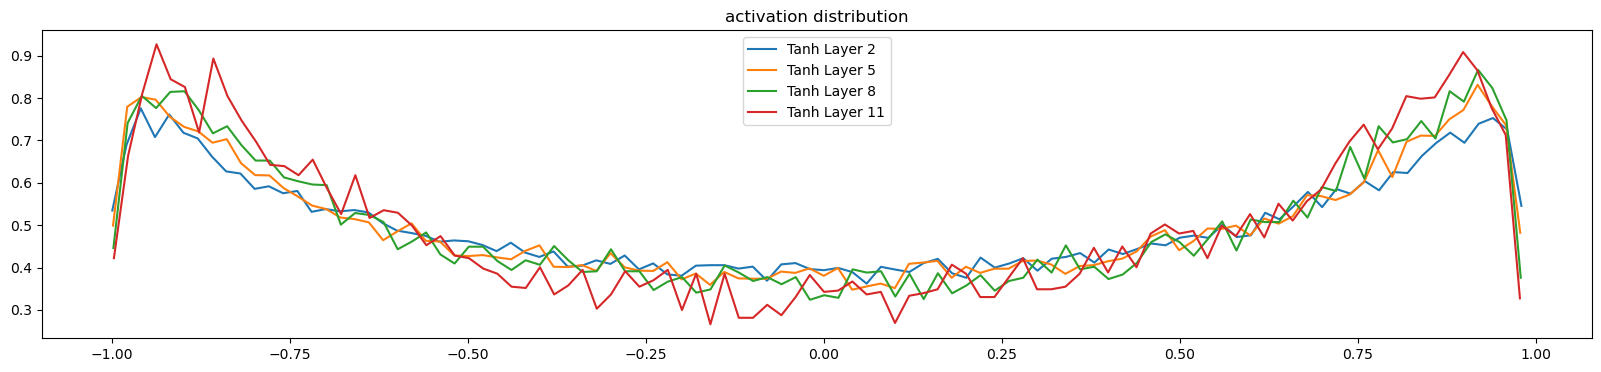

In [20]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"Layer {i}: mean {round(t.mean().item(), 3)} ; std {round(t.std().item(), 3)} ; saturated {(t.abs()>0.97).float().mean()*100}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Tanh Layer {i}")
plt.legend(legends)
plt.title('activation distribution')

Layer 2: mean 1.1368683772161603e-13 ; std 0.00010023030336014926
Layer 5: mean 8.526512829121202e-14 ; std 0.00016300279821734875
Layer 8: mean -3.197442310920451e-13 ; std 0.00023811761639080942
Layer 11: mean -6.326050794314142e-13 ; std 0.0002869659219868481


Text(0.5, 1.0, 'gradient distribution')

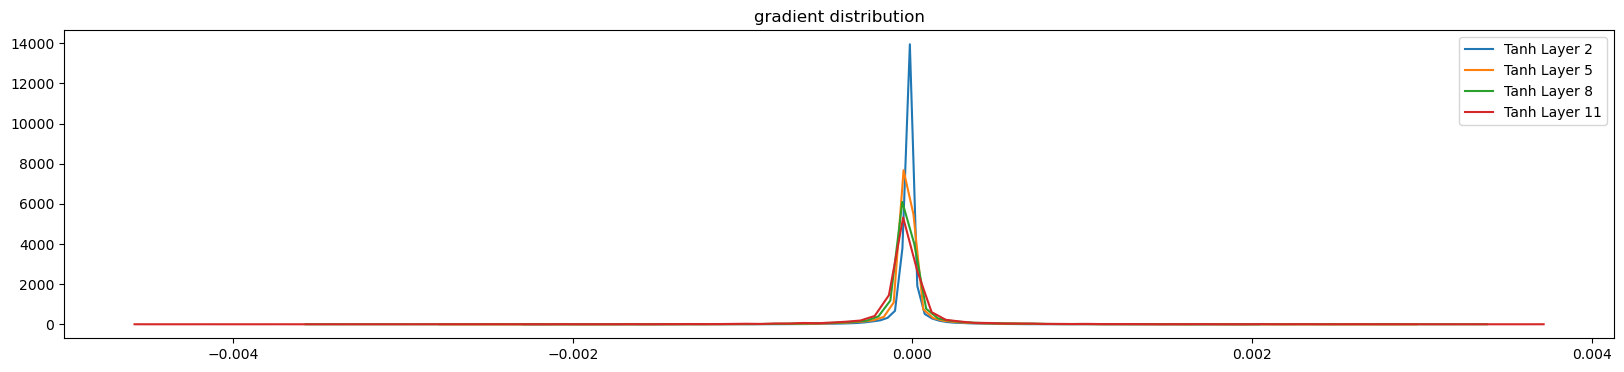

In [21]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"Layer {i}: mean {t.mean().item()} ; std {t.std().item()}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Tanh Layer {i}")
plt.legend(legends)
plt.title('gradient distribution')

Weight 0: mean 3.7553907077381155e-06 ; std 0.0010075633181259036 ; grad:data ratio 0.028169497847557068
Weight 3: mean -2.811040758388117e-06 ; std 0.001478066318668425 ; grad:data ratio 0.03337978571653366
Weight 6: mean -6.023565219948068e-06 ; std 0.002431074623018503 ; grad:data ratio 0.038864560425281525
Weight 9: mean -0.0001054833410307765 ; std 0.003457458456978202 ; grad:data ratio 0.0390574149787426
Weight 12: mean 0.0006746382568962872 ; std 0.007047189399600029 ; grad:data ratio 0.05503470078110695


Text(0.5, 1.0, 'weights gradient distribution')

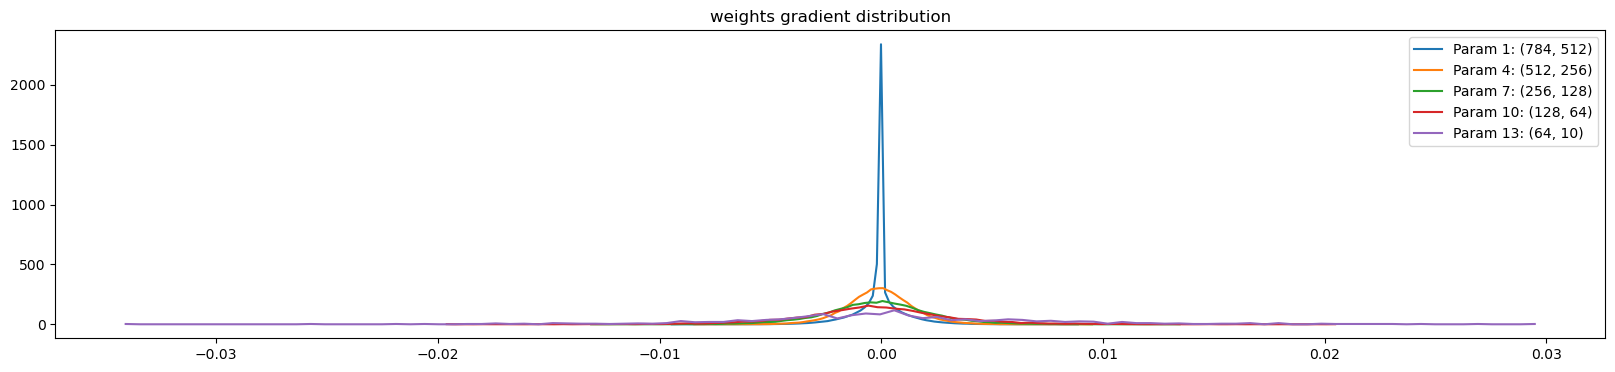

In [22]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim==2:
        print(f"Weight {i}: mean {t.mean().item()} ; std {t.std().item()} ; grad:data ratio {t.std()/p.std()}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Param {i+1}: {tuple(p.shape)}")
plt.legend(legends)
plt.title('weights gradient distribution')

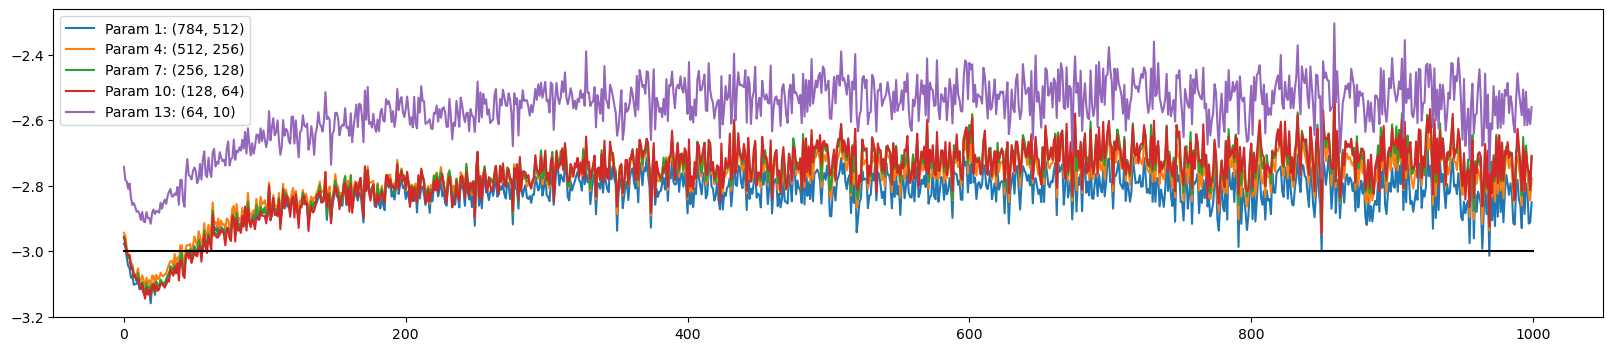

In [23]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([uds[j][i] for j in range(len(uds))])
        legends.append(f"Param {i+1}: {tuple(p.shape)}")
plt.plot([0, len(uds)], [-3, -3], 'k')
plt.legend(legends)

Batch Normalization (BatchNorm) significantly enhances model performance by ensuring that activations are more normally distributed. This is beneficial because it eliminates the need to fine-tune specific factors for each layer based on the desired activation. Additionally, the gradient-to-data ratio, helps in setting an appropriate learning rate. Ideally, we aim for this ratio to be close to 1e-3￼.

# X-AI: Visualisation of each activation according to the class

In [24]:
img2dic = {i:[] for i in range(10)}
for img, lab in test:
    if not len(img2dic[lab])>=10:
        img = img.view(784)
        img2dic[lab].append(img)
    if all([len(l)>=10 for l  in img2dic.values()]):
        break

img2dic = {i:torch.stack(img2dic[i]) for i in range(10)}

In [25]:
for l in layers:
    if isinstance(l, BatchNorm1d):
        l.training=False

with torch.no_grad():
    all_tensors = []
    for img in img2dic.values():
        tensors = []
        out = img.clone()
        for l in layers:
            out = l(out)
            if isinstance(l, Tanh):
                tensors.append(out)
        tensors = torch.cat(tensors, dim=1)
        all_tensors.append(tensors)
    all_tensors = torch.cat(all_tensors, dim=0)

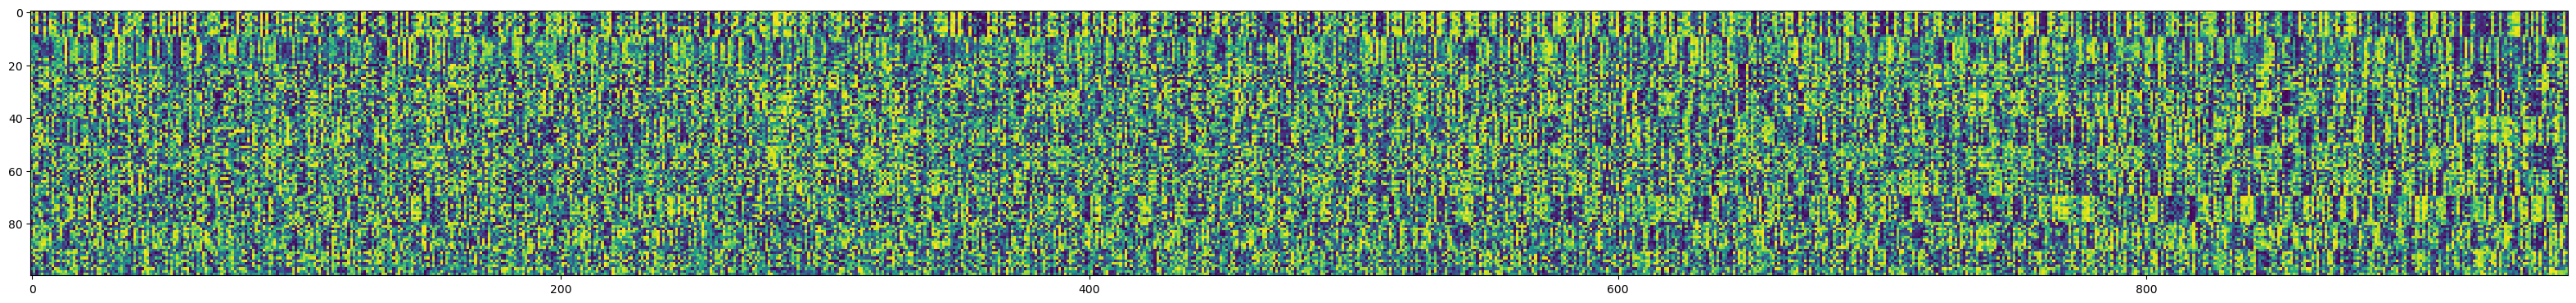

In [26]:
plt.figure(figsize=(40, 40))
plt.imshow(all_tensors)

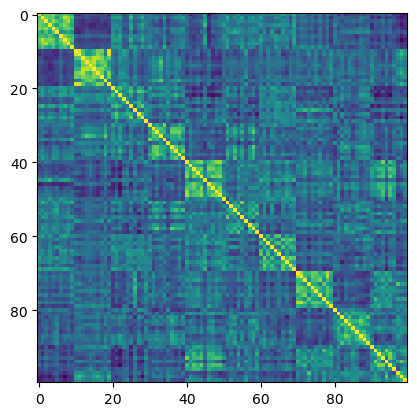

In [27]:
plt.imshow(torch.corrcoef(all_tensors))